In [1]:
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

## Get Data

In [11]:
tickers = {'Naked Brand Group':'NAKD', 'Koss':'KOSS',
                 'Zomedica':'ZOM','GameStop':'GME',
                 'AMC':'AMC',
                 'Express':'EXPR',
                 'Sundial Growers':'SNDL',
                'Palantir':'PLTR',
                  'Tilray':'TLRY'}

In [41]:
# set the start and end dates of the desired financial data
start = datetime.datetime(2018,11,1)
end = datetime.datetime(2021,2,10)

#tickers is a dictionary of the desired crypto currenceies and their yahoo tickers
tickers = {'Naked Brand Group':'NAKD', 'Koss':'KOSS',
                 'Zomedica':'ZOM','GameStop':'GME',
                 'AMC':'AMC',
                 'Express':'EXPR',
                 'Sundial Growers':'SNDL',
                'Palantir':'PLTR',
                  'Tilray':'TLRY'}

In [43]:
# the code below downloads the desired data
def get_data(tickers, start, end):
    crypto_prices = web.DataReader(list(tickers.values())[0], 'yahoo', start, end).reset_index()[['Date','Close']]
    crypto_volume = web.DataReader(list(tickers.values())[0], 'yahoo', start, end).reset_index()[['Date','Volume']]
    for ticker in list(tickers.values())[1:]:
        data = web.DataReader(ticker, 'yahoo', start, end).reset_index()
#         price = web.DataReader(ticker, 'yahoo', start, end).reset_index()[['Date','Close']]
        price = data[['Date','Close']]
        volume = data[['Date','Volume']]
        crypto_prices = crypto_prices.merge(price, left_on='Date', right_on='Date', how='outer')
        crypto_volume = crypto_volume.merge(volume, left_on='Date', right_on='Date', how='outer')
    crypto_prices = crypto_prices.set_index('Date')
    crypto_prices.columns = list(tickers.keys())
    crypto_volume = crypto_volume.set_index('Date')
    crypto_volume.columns = list(tickers.keys())
    return crypto_prices, crypto_volume 

prices, volume = get_data(tickers, start, end)

## Data Exploration

In [44]:
moving30 =  prices.rolling(window=30).mean()
moving90 = prices.rolling(window=90).mean()
daily_pc = prices.pct_change(1)
returns = prices/prices.shift(1)
log_ret = np.log(returns)
corr = log_ret.corr()

In [45]:
prices.pct_change(1).corr()

,Naked Brand Group,Koss,Zomedica,GameStop,AMC,Express,Sundial Growers,Palantir,Tilray
Naked Brand Group,1.000000,5.984405e-01,0.058954,0.371770,0.545695,0.457061,5.423847e-02,0.227965,0.011050
Koss,0.598440,1.000000e+00,-0.028571,0.603693,0.857243,0.731330,-9.921270e-07,0.159681,-0.012949
Zomedica,0.058954,-2.857104e-02,1.000000,-0.054138,-0.003453,-0.004596,8.429108e-02,-0.011787,0.072768
GameStop,0.371770,6.036934e-01,-0.054138,1.000000,0.619913,0.561161,-1.648867e-03,0.212175,0.089796
AMC,0.545695,8.572429e-01,-0.003453,0.619913,1.000000,0.776310,1.118813e-01,0.224225,0.086719
Express,0.457061,7.313298e-01,-0.004596,0.561161,0.776310,1.000000,1.012246e-01,0.295644,0.090691
Sundial Growers,0.054238,-9.921270e-07,0.084291,-0.001649,0.111881,0.101225,1.000000e+00,-0.077173,0.419156
Palantir,0.227965,1.596808e-01,-0.011787,0.212175,0.224225,0.295644,-7.717326e-02,1.000000,-0.059661
Tilray,0.011050,-1.294871e-02,0.072768,0.089796,0.086719,0.090691,4.191562e-01,-0.059661,1.000000


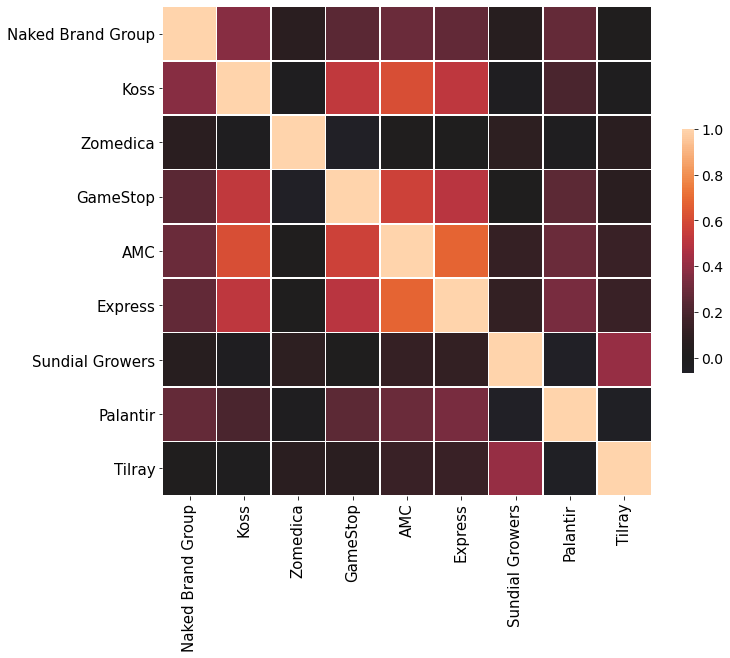

In [46]:
font = {'size' : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr,cbar_kws={"shrink": .5},linewidths=.5,square=True, center=0 )
ax.tick_params(labelsize=15)

## Monte Carlo Simulation

In [47]:
def monte_carlo(log_ret, n_portfolios=5000):
    n_currencies = log_ret.shape[1]
    # Mean Log Return
    mean_log_ret = log_ret.mean()
    # Covariance Matrix
    sigma = log_ret.cov()
    # Weight Matrix
    all_weights = np.zeros((n_portfolios,n_currencies))
    # Expected Return array
    ret_arr = np.zeros(n_portfolios)
    # Expected Volatility array
    vol_arr = np.zeros(n_portfolios)
    # Sharpe Ratio array
    sharpe_arr = np.zeros(n_portfolios) 
    
    for k in range(n_portfolios):
        # Weights
        weights = np.array(np.random.random(n_currencies))
        weights = weights/np.sum(weights)
        # Save Weights
        all_weights[k,:] = weights
        # Expected Log Returns
        ret_arr[k] = np.sum(mean_log_ret * weights * 356)
        # expected volatility
        vol_arr[k] = np.sqrt(np.dot(weights.T, np.dot(sigma*365,weights)))
        #sharpe ratio
        sharpe_arr[k] = ret_arr[k]/vol_arr[k]
            
    return ret_arr, vol_arr, sharpe_arr, all_weights
 

In [51]:
ret_arr, vol_arr, sharpe_arr, best_weights = monte_carlo(log_ret, n_portfolios=50000)
max_index = sharpe_arr.argmax()

In [52]:
best_weights[max_index]

array([0.00678625, 0.1766063 , 0.17835737, 0.0865056 , 0.00693259,
       0.02888329, 0.02260728, 0.3279229 , 0.16539842])

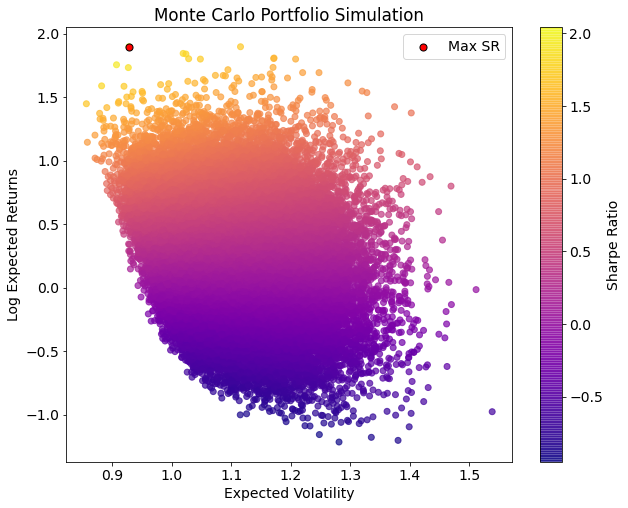

In [53]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=.7)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_arr[max_index], 
            ret_arr[max_index], c='red', s=50, edgecolors='black', label='Max SR')
plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.title('Monte Carlo Portfolio Simulation')
plt.legend()

## Optimization

In [54]:
def get_ret_vol_sr(weights):
    # Mean Log Return
    mean_log_ret = log_ret.mean()
    # Covariance Matrix
    sigma = log_ret.cov()
    
    weights = np.array(weights)
    ret = np.sum(mean_log_ret * weights) * 356
    vol = np.sqrt(np.dot(weights.T, np.dot(sigma*356, weights)))
    sr = ret/vol
    
    return np.array([ret,vol,sr])

In [55]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [56]:
def check_sum(weights):
    # returns 0 if sum of the weights is 1
    return np.sum(weights) - 1 

n_currencies = prices.shape[1]
constraints = ({'type':'eq','fun':check_sum})
bounds = tuple([(0,1) for i in range(n_currencies)])
x0 = [1/n_currencies for i in range(n_currencies)]

In [57]:
opt_results = minimize(neg_sharpe, x0, method='SLSQP', 
                       bounds=bounds, constraints=constraints)

In [58]:
opt_weights = list(opt_results.x)

In [59]:
[round(i,3) for i in opt_weights]

[0.0, 0.0, 0.038, 0.0, 0.0, 0.0, 0.0, 0.939, 0.023]

In [60]:
get_ret_vol_sr(opt_results.x)

array([4.86689569, 1.18185478, 4.11801499])

## Analysis

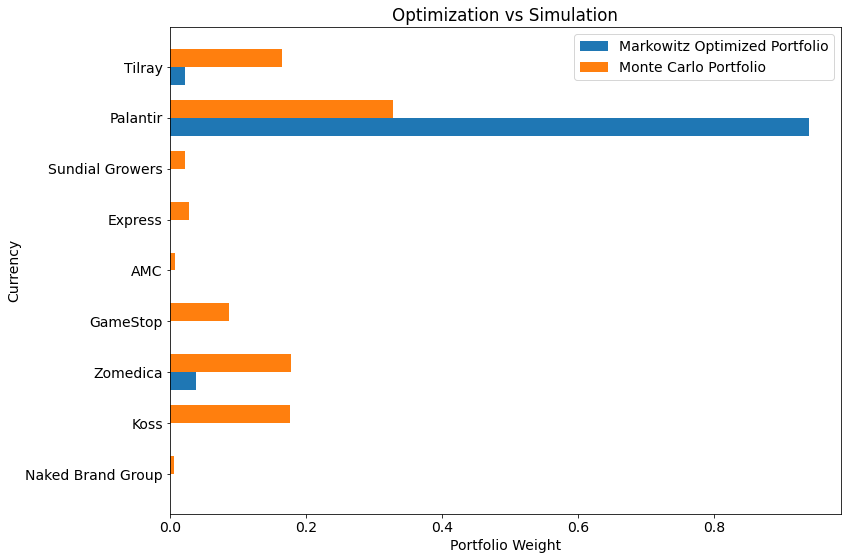

In [61]:
labels = list(tickers.keys())
meanvar_weights = [round(i,13) for i in list(opt_results.x)]
mc_weights = [round(i,13) for i in list(best_weights[max_index])]

y = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.barh(y - width/2, meanvar_weights, width, label='Markowitz Optimized Portfolio')
rects2 = ax.barh(y + width/2, mc_weights, width, label='Monte Carlo Portfolio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Portfolio Weight')
ax.set_ylabel('Currency')
ax.set_title('Optimization vs Simulation')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### Efficient Frontier

In [62]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [63]:
frontier_y = np.linspace(ret_arr.min() -.5, ret_arr.max()+.5, 50)
frontier_volatility = []

for possible_return in frontier_y:
    constraints = ({'type':'eq', 'fun': check_sum}, 
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, x0,  method='SLSQP', 
                       bounds=bounds, constraints=constraints)
    frontier_volatility.append(result['fun'])

Text(0.5, 1.0, 'Efficient Frontier')

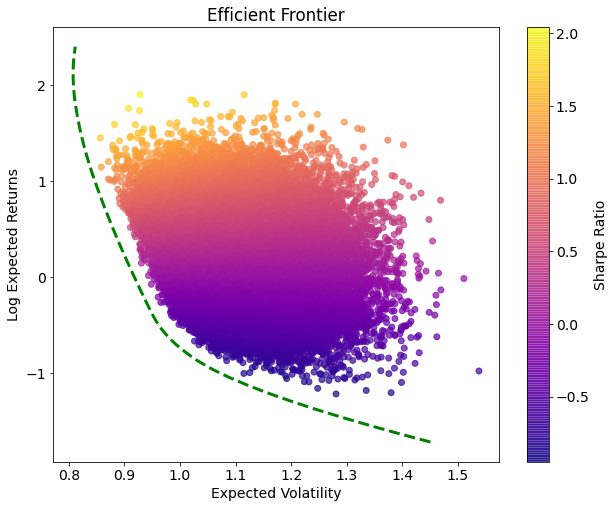

In [64]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=.7)
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(vol_arr[max_index], 
#             ret_arr[max_index], c='red', s=50, edgecolors='black', label='Max SR')
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)

plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.title('Efficient Frontier')

## Analysis

In [65]:
principal = 10000
meanvar_folio = [i*principal for i in meanvar_weights] / prices.loc[start] 
mc_folio = [i*principal for i in mc_weights] / prices.loc[start] 

In [66]:
meanvar_profits = meanvar_folio * prices.loc[end]
mc_profits = mc_folio * prices.loc[end]

In [68]:
meanvar_profits

Naked Brand Group      0.000000
Koss                   0.000000
Zomedica             554.073149
GameStop               0.000000
AMC                    0.000000
Express                0.000000
Sundial Growers             NaN
Palantir                    NaN
Tilray               148.470818
dtype: float64

In [69]:
print(sum(meanvar_profits))
print(sum(mc_profits))

nan
nan


## Max Diversification

In [70]:
def neg_div_ratio(weights):
    weights = np.array(weights)
    sigma = log_ret.cov()
   
    w_vol = np.dot(np.sqrt(np.diag(sigma)), weights.T)
    port_vol = np.sqrt(np.dot(np.dot(weights.T,sigma),weights))
    diversification_ratio = w_vol/port_vol
    return -1*diversification_ratio

In [71]:
neg_div_ratio(x0)

-1.7678875086740373

In [72]:
max_div_results = minimize(neg_div_ratio, x0, method='SLSQP', 
                       bounds=bounds, constraints=constraints)

In [73]:
max_div_results

     fun: -1.8655542969293173
     jac: array([-0.46288867, -0.24473359, -0.42406169, -0.26144186,  0.45643179,
        0.50792161, -0.66296977,  0.54635724, -0.52462021])
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00000000e+00, 7.45119436e-02, 1.83004743e-01, 0.00000000e+00,
       7.24224464e-16, 0.00000000e+00, 1.23628897e-01, 4.69166425e-01,
       1.49687991e-01])

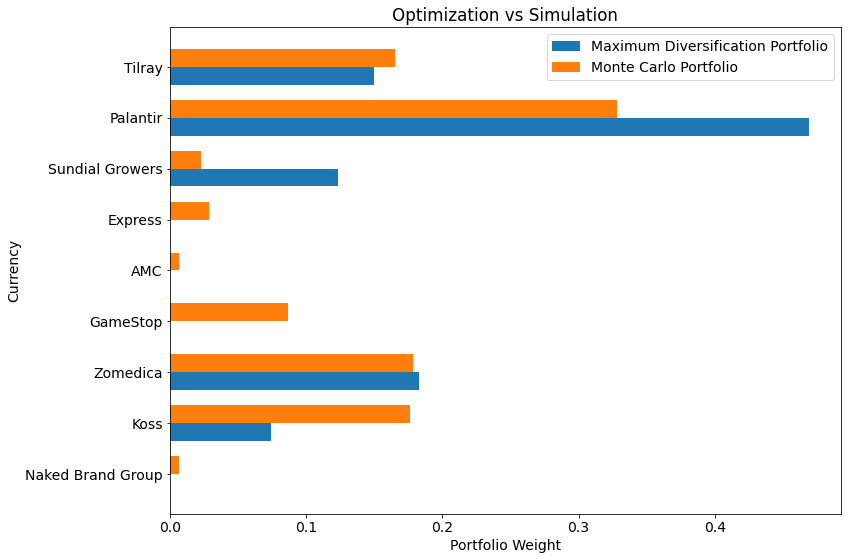

In [74]:
labels = list(tickers.keys())
maxdiv_weights = [round(i,13) for i in list(max_div_results.x)]
mc_weights = [round(i,13) for i in list(best_weights[max_index])]

y = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.barh(y - width/2, maxdiv_weights, width, label='Maximum Diversification Portfolio')
rects2 = ax.barh(y + width/2, mc_weights, width, label='Monte Carlo Portfolio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Portfolio Weight')
ax.set_ylabel('Currency')
ax.set_title('Optimization vs Simulation')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [75]:
principal = 10000
maxdiv_folio = [i*principal for i in maxdiv_weights] / prices.loc[start] 
mc_folio = [i*principal for i in mc_weights] / prices.loc[start] 

In [76]:
max_div_profits = maxdiv_folio * prices.loc[end]
mc_profits = mc_folio * prices.loc[end]

## Portfolio Comparison

In [77]:
#weights
np.random.seed(31)
random_weights = np.random.random(n_currencies)
random_weights = random_weights/sum(random_weights)

maxdiv_weights = [round(i,13) for i in list(max_div_results.x)]

mc_weights = [round(i,13) for i in list(best_weights[max_index])]

meanvar_weights = [round(i,13) for i in list(opt_results.x)]

evenweights = x0

In [78]:
evenfolio = [i*principal for i in evenweights] / prices.loc[start] 
even_profits = evenfolio * prices.loc[end]

In [79]:
randomfolio = [i*principal for i in random_weights] / prices.loc[start] 
random_profits = randomfolio * prices.loc[end]

In [80]:
# bitfolio = principal/prices['Bitcoin'][start]
# bitfolio_returns = bit * prices['Bitcoin'][end]

In [81]:
portfolios = pd.DataFrame({'Portfolio Type':['Random','Even Split','Monte Carlo','Mean Variance', 'Maximum Diversification'], 
                           'Profit':[sum(random_profits), sum(even_profits), sum(mc_profits),sum(meanvar_profits),sum(max_div_profits)]})
portfolios = portfolios.sort_values(by='Profit', ascending=False)
portfolios.Profit = [round(i,2)-principal for i in portfolios.Profit]

(0.0, 12000.0)

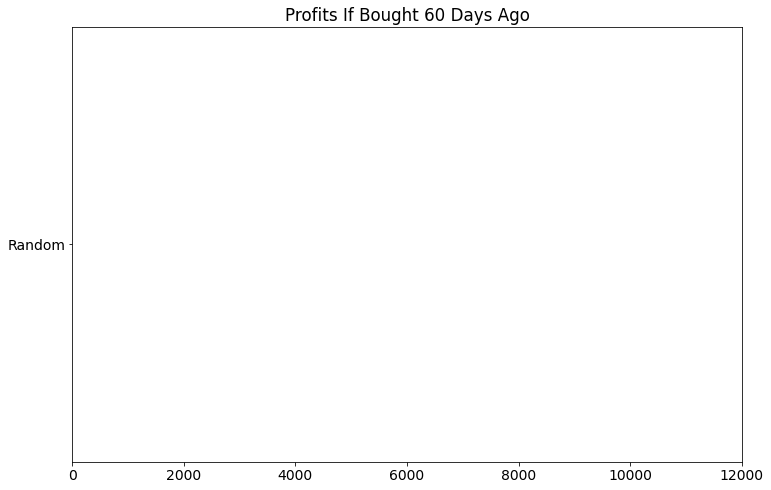

In [82]:
plt.figure(figsize=(12,8))
plt.barh(portfolios['Portfolio Type'],portfolios['Profit'])
plt.title('Profits If Bought 60 Days Ago')
plt.xlim(0,12000)

In [83]:
portfolio_list = [evenfolio, randomfolio, mc_folio, maxdiv_folio, meanvar_folio]

def backtest(portfolio_list,start,end):
    date_range = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    montecarlo = [sum(mc_folio*prices.loc[i]) for i in date_range]
    meanvar = [sum(meanvar_folio*prices.loc[i]) for i in date_range]
    maxdiv = [sum(maxdiv_folio*prices.loc[i]) for i in date_range]
    even = [sum(evenfolio*prices.loc[i]) for i in date_range]
    random = [sum(randomfolio*prices.loc[i]) for i in date_range]
    data = pd.DataFrame({'Random':random, 'Even Split':even, 'Monte Carlo':montecarlo, 'Maximum Diversification':maxdiv,
    'Mean Variance':meanvar}, index=date_range)
    port_val_over_time = pd.DataFrame(index=date_range, columns=['Random','Even Split','Monte Carlo',
                                            'Mean Variance', 'Maximum Diversification'], data=data)
    return port_val_over_time

In [84]:
port_val_over_time = backtest(portfolio_list, start, end)

KeyError: Timestamp('2018-11-03 00:00:00')

Text(0.5, 1.0, 'Backtest')

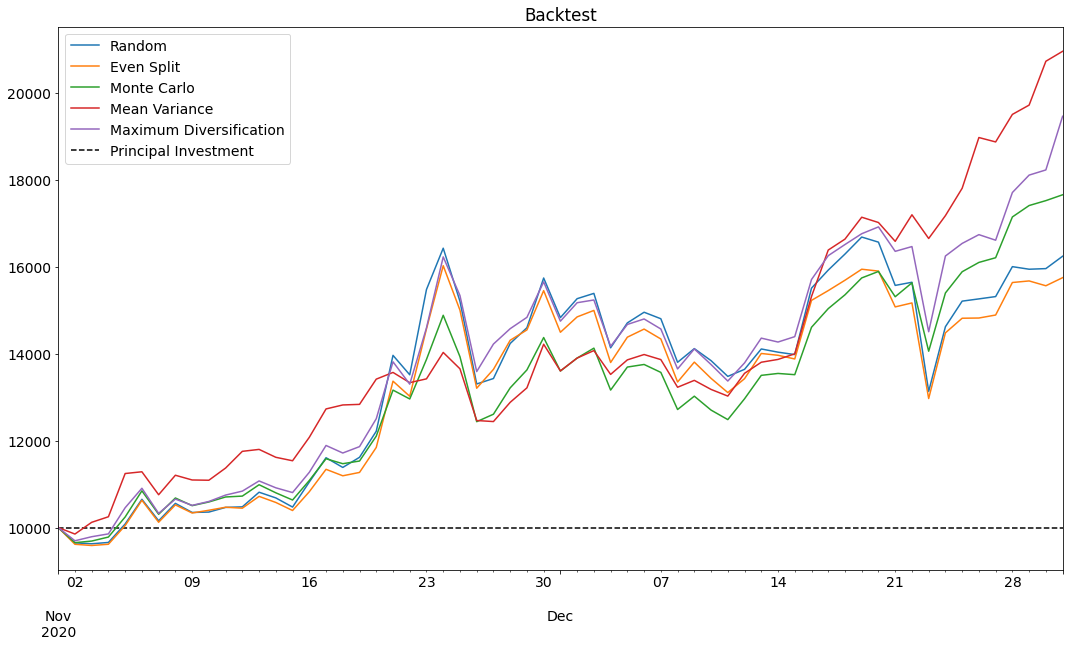

In [62]:
port_val_over_time.plot(figsize=(18,10))
plt.hlines(y=10000, xmin=start, xmax=end, linestyles='--', label='Principal Investment')
plt.legend()
plt.title('Backtest')